###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# From 2D acoustic to 2D SH finite difference modelling

In the last [lesson](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/06_2D_SH_Love_wave_modelling/1_2D_SH_FD_staggered.ipynb), we derived a 2nd order space/time finite difference solution on a staggered Cartesian grid to solve the 2D isotropic elastic SH problem. In the next step we will implement this FD scheme starting from our 2D acoustic code ...

## FD solution of 2D isotropic SH problem

The 2nd order space/time FD scheme on a staggered grid 

<img src="images/SG_SH-Cart.png" width="50%">

using explicit time-stepping with the Leapfrog method to solve the 2D SH problem can be written as 

\begin{align}
\scriptsize 
v_y(i,j,n+1/2) &\scriptsize= \frac{dt}{\rho}\biggl\{\biggl(\frac{\partial \sigma_{yx}}{\partial x}\biggr)^c(i,j,n) + \biggl(\frac{\partial \sigma_{yz}}{\partial z}\biggl)^c(i,j,n) + f_y(i,j,n)\biggr\} + v_y(i,j,n-1/2), \notag\\
\scriptsize\sigma_{yx}(i+1/2,j,n+1) &\scriptsize= dt\; \mu_x \biggl(\frac{\partial v_{y}}{\partial x}\biggr)^c(i+1/2,j,n+1/2) + \sigma_{yx}(i+1/2,j,n),\notag\\
\scriptsize\sigma_{yz}(i,j+1/2,n+1) &\scriptsize= dt\; \mu_z \biggl(\frac{\partial v_{y}}{\partial z}\biggr)^c(i,j+1/2,n+1/2) + \sigma_{yz}(i,j+1/2,n), \notag\\
\end{align}

with the spatial derivatives on the RHS approximated by

\begin{equation}
\scriptsize \biggl(\frac{\partial \sigma_{yx}}{\partial x}\biggr)^c(i,j) \approx \frac{\sigma_{yx}(i+1/2,j) - \sigma_{yx}(i-1/2,j)}{dx},\; 
\biggl(\frac{\partial \sigma_{yz}}{\partial z}\biggr)^c(i,j) \approx \frac{\sigma_{yz}(i,j+1/2) - \sigma_{yz}(i,j-1/2)}{dz},\notag
\end{equation}

\begin{equation}
\scriptsize \biggl(\frac{\partial v_{y}}{\partial x}\biggr)^c(i+1/2,j) \approx \frac{v_y(i+1,j) - v_{y}(i,j)}{dx},\notag 
\end{equation}

\begin{equation}
\scriptsize \biggl(\frac{\partial v_{y}}{\partial x}\biggr)^c(i,j+1/2) \approx \scriptsize \frac{v_y(i,j+1) - v_{y}(i,j)}{dz}.\notag 
\end{equation}

and the harmonically averaged shear moduli:

\begin{align}
\mu_{x} &= \mu(i+1/2,j) = 2 \biggl[\biggl(\mu^{-1}_{i,j}+\mu^{-1}_{i+1,j}\biggr)\biggr]^{-1} \notag\\
\mu_{z} &= \mu(i,j+1/2) = 2 \biggl[\biggl(\mu^{-1}_{i,j}+\mu^{-1}_{i,j+1}\biggr)\biggr]^{-1} \notag
\end{align}

### Initial and boundary conditions

Because we have analytical solutions for wave propagation in homogeneous media, we should test our first code implementation for a similar medium, by setting density $\rho$ and shear modulus $\mu$ to constant values $\rho_0,\; \mu_0$

\begin{align}
\rho(i,j) &= \rho_0 \notag \\
\mu(i,j) &= \mu_0 = \rho_0 V_{s0}^2\notag
\end{align}

at each spatial grid point $i = 0, 1, 2, ..., nx$; $j = 0, 1, 2, ..., nz$, in order to compare the numerical with the analytical solution. For a complete description of the problem we also have to define initial and boundary conditions. The **initial condition** is 

\begin{equation}
v_y(i,j,0) = \sigma_{yx}(i+1/2,j,0) = \sigma_{yz}(i,j+1/2,0) = 0, \nonumber
\end{equation}

so the modelling starts with zero particel velocity and shear stress amplitudes at each spatial grid point. As **boundary conditions**, we assume 

\begin{align}
v_y(0,j,n) &= \sigma_{yx}(1/2,j,n) = \sigma_{yz}(0,j+1/2,n) = 0, \nonumber\\
v_y(nx,j,n) &= \sigma_{yx}(nx+1/2,j,n) = \sigma_{yz}(nx,j+1/2,n) = 0, \nonumber\\
v_y(i,0,n) &= \sigma_{yx}(i+1/2,0,n) = \sigma_{yz}(i,1/2,n) = 0, \nonumber\\
v_y(i,nz,n) &= \sigma_{yx}(i+1/2,nz,n) = \sigma_{yz}(i,nz+1/2,n) = 0, \nonumber\\
\end{align}

for all time steps n. This **Dirichlet boundary condition**, leads to artifical boundary reflections which would obviously not describe a homogeneous medium. For now, we simply extend the model, so that boundary reflections are not recorded at the receiver positions.

Let's implement it ...

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax  # maximum spatial extension of the 1D model in z-direction(m)
#dx   = 1.0   # grid point distance in x-direction
#dz   = dx    # grid point distance in z-direction

tmax = 0.502   # maximum recording time of the seismogram (s)
#dt   = 0.0010  # time step

vs0  = 580.   # S-wave speed in medium (m/s)
rho0 = 1000.  # Density in medium (kg/m^3)

# acquisition geometry
xr = 330.0 # x-receiver position (m)
zr = xr    # z-receiver position (m)

xsrc = 250.0 # x-source position (m)
zsrc = 250.0 # z-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

## Comparison of 2D finite difference with analytical solution for homogeneous Vs model

In a previous [exercise](https://danielkoehnsite.files.wordpress.com/2018/04/ex_02_tew21.pdf) you proved that the analytical solutions for the homogeneous 2D acoustic and 2D SH problem, beside a density factor $1/\rho_0$, are actual identical . In the function below we solve the homogeneous 2D SH problem by centered 2nd order spatial/temporal difference operators and compare the numerical results with the analytical solution: 

\begin{equation}
u_{y,analy}(x,z,t) = G_{2D} * S \nonumber 
\end{equation}

with the 2D Green's function:

\begin{equation}
G_{2D}(x,z,t) = \dfrac{1}{2\pi \rho_0 V_{s0}^2}\dfrac{H\biggl((t-t_s)-\dfrac{|r|}{V_{s0}}\biggr)}{\sqrt{(t-t_s)^2-\dfrac{r^2}{V_{s0}^2}}}, \nonumber 
\end{equation}

where $H$ denotes the Heaviside function, $r = \sqrt{(x-x_s)^2+(z-z_s)^2}$ the source-receiver distance (offset) and $S$ the source wavelet. Keep in mind that the stress-velocity code computes the **particle velocities** $\mathbf{v_{y,analy}}$, while the analytical solution is expressed in terms of the **displacement** $\mathbf{u_{y,analy}}$. Therefore, we have to take the first derivative of the analytical solution, before comparing the numerical with the analytical solution:

\begin{equation}
v_{y,analy}(x,z,t) = \frac{\partial u_{y,analy}}{\partial t} \nonumber 
\end{equation}

To implement the 2D SH code, we first introduce functions to update the particle velocity $v_y$ ...

In [4]:
# Particle velocity vy update
# ---------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
            
            # Calculate spatial derivatives            
            syx_x = (syx[i,j] - syx[i - 1,j]) / dx
            syz_z = (syz[i,j] - syz[i,j - 1]) / dz
            
            # Update particle velocities
            vy[i,j] = vy[i,j] + (dt/rho[i,j]) * (syx_x + syz_z)                
                    
    return vy

... update the shear stress components $\sigma_{yx}$ and $\sigma_{yz}$ ...

In [5]:
# Shear stress syx, syz updates
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
            
            # Calculate spatial derivatives            
            vy_x = (vy[i + 1,j] - vy[i,j]) / dx
            vy_z = (vy[i,j + 1] - vy[i,j]) / dz
            
            # Update shear stresses
            syx[i,j] = syx[i,j] + dt * mux[i,j] * vy_x
            syz[i,j] = syz[i,j] + dt * muz[i,j] * vy_z
                    
    return syx, syz

... and harmonically averaging the shear modulus ...

In [6]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nx, nz, mux, muz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
            
            # Calculate harmonic averages of shear moduli        
            mux[i,j] = 2 / (1 / mu[i + 1,j] + 1 / mu[i,j])
            muz[i,j] = 2 / (1 / mu[i,j + 1] + 1 / mu[i,j])
            
    return mux, muz

Finally, we can modify the main FD code ...

In [7]:
# 2D SH Wave Propagation (Finite Difference Solution) 
# ---------------------------------------------------
def FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc):
        
    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)
    
    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    jr = (int)(zr/dz)      # receiver location in grid in z-direction
    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # Analytical solution
    # -------------------
    G        = time * 0.
    vy_analy = time * 0.

    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinates in x-direction (m)

    z    = np.arange(nz)
    z    = z * dz       # coordinates in z-direction (m)
    
    # calculate source-receiver distance
    r = np.sqrt((x[ir] - x[isrc])**2 + (z[jr] - z[jsrc])**2)
    
    for it in range(nt): # Calculate Green's function (Heaviside function)
        if (time[it] - r / vs0) >= 0:
            G[it] = 1. / (2 * np.pi * rho0 * vs0**2) * (1. / np.sqrt(time[it]**2 - (r/vs0)**2))
    Gc   = np.convolve(G, src * dt)
    Gc   = Gc[0:nt]
    
    # compute vy_analy from uy_analy
    for i in range(1, nt - 1):
        vy_analy[i] = (Gc[i+1] - Gc[i-1]) / (2.0 * dt)           
    
    # Initialize empty pressure arrays
    # --------------------------------
    vy    = np.zeros((nx,nz)) # particle velocity vy
    syx   = np.zeros((nx,nz)) # shear stress syx
    syz   = np.zeros((nx,nz)) # shear stress syz        

    # Initialize model (assume homogeneous model)
    # -------------------------------------------    
    vs    = np.zeros((nx,nz))
    vs    = vs + vs0      # initialize wave velocity in model
    
    rho   = np.zeros((nx,nz))
    rho   = rho + rho0    # initialize wave velocity in model
    
    # calculate shear modulus
    mu    = np.zeros((nx,nz))
    mu    = rho * vs ** 2 
    
    # harmonic average of shear moduli
    # --------------------------------
    mux   = mu # initialize harmonic average mux 
    muz   = mu # initialize harmonic average muz

    mux, muz = shear_avg(mu, nx, nz, mux, muz)
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Time looping
    # ------------
    for it in range(nt):
    
        # Update particle velocity vy
        # ---------------------------
        vy = update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho)

        # Add Source Term at (isrc,jsrc)
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vy[isrc,jsrc] = vy[isrc,jsrc] + (dt * src[it] / (rho[isrc,jsrc] * dx * dz))
        
        # Update shear stress syx, syz
        # ----------------------------
        syx, syz = update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz)                
                           
        # Output of Seismogram
        # -----------------
        seis[it] = vy[ir,jr]   
        
    # Compare FD Seismogram with analytical solution
    # ---------------------------------------------- 
    # Define figure size
    rcParams['figure.figsize'] = 12, 5
    plt.plot(time, seis, 'b-',lw=3,label="FD solution") # plot FD seismogram
    Analy_seis = plt.plot(time,vy_analy,'r--',lw=3,label="Analytical solution") # plot analytical solution
    plt.xlim(time[0], time[-1])
    plt.title('Seismogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()     
    
    return mux, muz

nx =  500
nz =  500
nt =  502


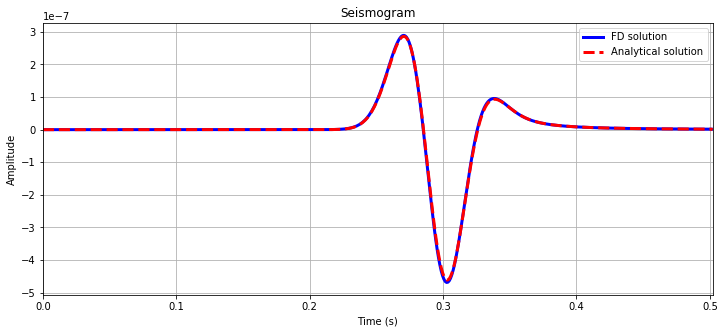

CPU times: user 1.42 s, sys: 20 ms, total: 1.44 s
Wall time: 833 ms


In [9]:
%%time

dx   = 1.0   # grid point distance in x-direction (m)
dz   = dx    # grid point distance in z-direction (m)

dt = 0.001   # time step (s)

mux, muz = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc)

## What we learned:

* Implementation of the 2D isotropic elastic SH problem based on our 2D acoustic FD code 
* Comparison with analytical solution for homogeneous Vs model